In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from fastai.text import *


In [2]:
PATH='C:\\Users/Marco/Projects/dantegen/'

In [14]:
#fpath = get_file(PATH + 'data/raw/divcomm.txt', origin="http://www.gutenberg.org/files/1012/1012-0.txt")
fpath = PATH + 'data/raw/divcomm.txt'
text = open(fpath,encoding='utf8').read().lower()
text = text[932:-19658]

In [ ]:
text_all = ' ",\n"'.join(text)
with open(PATH + "data/raw/divcomm.csv", "w+") as text_file:
    text_file.write(text_all)

In [3]:
df = pd.read_csv(PATH + "data/raw/divcomm.csv", header = None, encoding = 'latin1')
df = df.drop(1, axis = 1)
df[1] = 0

In [4]:
data_lm = TextLMDataBunch.from_df(path = PATH + 'data/processed/', train_df = df[:-500], 
                                  valid_df = df[-500:], text_cols = 0, bs = 16)

In [5]:
data_lm.save(PATH + 'models/fastai_data_lm_export_bs16.pkl')

In [21]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained = False)

In [22]:
learner.unfreeze()

In [23]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


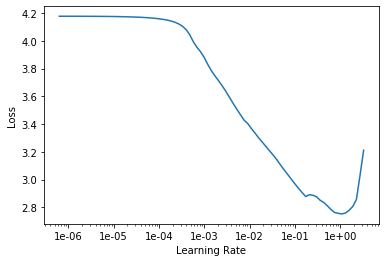

In [24]:
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(1, 5e-1)

epoch,train_loss,valid_loss,accuracy,time
0,3.849978,2.928428,0.556250,21:35


In [13]:
learner.save(PATH + 'models/fastai_data_lm_export_bs16_trained1.pkl')

In [18]:
learner.unfreeze()

In [19]:
learner.fit_one_cycle(1, 1e-3, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.056403,2.041789,0.556250,23:57


In [29]:
learner.predict("N e l   m e z z o   d e l   c a m m i n   d i   n o s t r a   v i t a \n ", n_words = 50)

'N e l   m e z z o   d e l   c a m m i n   d i   n o s t r a   v i t a \n  xxbos s xxbos r xxbos ; xxbos ; xxbos ; xxbos a xxbos s xxbos ; xxbos ; xxbos u xxbos ; xxbos ; xxbos u xxbos t xxbos s xxbos a xxbos ; xxbos s xxbos ; xxbos s xxbos s xxbos s xxbos ; xxbos ; xxbos xxbos'

In [ ]:
chars = sorted(list(set(text)))
chars.insert(0, "\0")
vocab_size = len(chars)
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
idx = [char_indices[c] for c in text]

In [ ]:
maxlen = 40
c_in_dat = [[idx[i+j] for i in range(maxlen)] for j in range(len(idx)-maxlen-1)]
xs = np.stack(c_in_dat, axis=0)
c_out_dat = [idx[j+maxlen] for j in range(len(idx)-maxlen-1)]
y = np.stack(c_out_dat)

In [ ]:
"".join(indices_char[i] for i in xs[0])

In [ ]:
xs.shape,y.shape

In [ ]:
n_hidden = 256
n_fac = 42

In [ ]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        
        return F.log_softmax(self.l_out(outp[-1]))#, dim=-1)

In [ ]:
m = CharRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
val_idx = get_cv_idxs(len(idx)-maxlen-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [ ]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [ ]:
t = m.e(V(torch.stack(xs)))
t.size()

In [ ]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

In [ ]:
t = m(*V(xs)); t.size()

In [ ]:
fit(m, md, 4, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
fit(m, md, 2, opt, F.nll_loss)

In [ ]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [ ]:
def get_next_n(inp = "nel mezzo del cammin di nostra vita\n  mi", n = 500):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
print(get_next_n())

In [ ]:
len(text)*0.2

In [ ]:
PATH='/home/ubuntu/projects/dantegen/data/processed/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

In [ ]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=40; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

In [ ]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [ ]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(torch.stack(cs)), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp)[-1])#.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [ ]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
# new version
m = CharSeqStatefulLSTM(vocab_size, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [ ]:
t = m.e(V(torch.stack(xs)))
t.size()

In [ ]:
#ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t,m.h)
#outp.size(), hn.size()

In [ ]:
F.log_softmax(m.l_out(outp[-1]))

In [ ]:
fit(m, md, 2, lo.opt, F.nll_loss)

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'/home/ubuntu/projects/dantegen/models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'/home/ubuntu/projects/dantegen/models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

In [ ]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    ps= np.exp(p)/np.sum(np.exp(p))
    c = np.random.choice(chars,p=ps)
    return c

In [ ]:
def get_next_n(inp = "nel mezzo del cammin di nostra vita\n  mi", n = 500):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
print(get_next_n())

In [ ]:
maxlen = 125
c_in_dat = [[idx[i+j] for i in range(maxlen)] for j in range(len(idx)-maxlen-1)]
xs = np.stack(c_in_dat, axis=0)
c_out_dat = [idx[j+maxlen] for j in range(len(idx)-maxlen-1)]
y = np.stack(c_out_dat)

In [ ]:
"".join(indices_char[i] for i in xs[0])

In [ ]:
xs.shape,y.shape

In [ ]:
n_hidden = 256
n_fac = 42

In [ ]:
val_idx = get_cv_idxs(len(idx)-maxlen-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [ ]:
m = CharSeqStatefulLSTM(vocab_size, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
fit(m, md, 2, lo.opt, F.nll_loss)

In [ ]:
def get_next_n(inp = "nel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura,\n  ché la diritta via era smarrita.\n\n  ahi quanto a di", n = 500):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
print(get_next_n())

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'/home/ubuntu/projects/dantegen/models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**3-1, lo.opt, F.nll_loss, callbacks=cb)

In [ ]:
print(get_next_n())

In [ ]:
print(get_next_n())

In [ ]:
n_hidden = 512
n_fac = 42

In [ ]:
m = CharSeqStatefulLSTM(vocab_size, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
fit(m, md, 2, lo.opt, F.nll_loss)

In [ ]:
print(get_next_n())

In [ ]:
save_model(m,'/home/ubuntu/projects/dantegen/models/512cells125ch2ep')